In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]


In [3]:
%%time
list_basins = pd.read_csv('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/data/basin_list.txt', dtype=str, names=['site_no']).site_no.to_list()
LSTM_aorc = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_aorc_gagesII_trained_on_2005_2021/ealstm_seed588170.p')
LSTM_c404 = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_c404_gagesII_trained_on_2005_2020/ealstm_seed95734.p')

usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]



CPU times: user 971 ms, sys: 59.9 ms, total: 1.03 s
Wall time: 1.18 s


In [4]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs

    sim_log = np.log(sim+0.0001)
    sim_mean = np.mean(sim)
    sim_std = np.std(sim)
    
    obs_log = np.log(obs+0.0001)
    obs_mean = np.mean(obs)
    obs_std = np.std(obs)

    Bias = sim_mean - obs_mean
    Err = sim-obs
    MSE = np.mean(Err**2)
    RMSE = np.sqrt(MSE)
    RRMSE = RMSE / obs_mean
    
    corr_pear = obs.corr(sim) 
    corr_rank = obs.corr(sim, method='spearman')
    
    if obs_std == 0:
        KGE_alpha = np.nan
        NSE_C = np.nan
    else:
        KGE_alpha = sim_std  / obs_std
        NSE_C = (Bias / obs_std)**2
    
    if obs_mean == 0:
        Bias_perc = np.nan
        KGE_beta = np.nan
    else:
        Bias_perc = 100*Bias / obs_mean
        KGE_beta  = sim_mean / obs_mean

    NSE_A = corr_pear**2
    NSE_B = (corr_pear - KGE_alpha)**2
    

    NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
    KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
    LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
    WtNSE = (0.5*NSE) + (0.5*LogNSE)
    
    out_df = pd.DataFrame({'mean_obs':obs_mean,
                           'mean_sim':sim_mean, 
                           'std_obs':obs_std,
                           'std_sim':sim_std, 
                           'Bias': Bias,
                           'Bias_perc': Bias_perc,
                           'corr_pear': corr_pear,
                           'corr_rank': corr_rank,
                           'NSE': NSE,
                           'KGE': KGE,
                           'LogNSE': LogNSE,
                           'WtNSE': WtNSE,
                           'MSE': MSE,
                           'RMSE': RMSE,
                           'RRMSE': RRMSE,
                           'NSE_A':NSE_A, 
                           'NSE_B':NSE_B, 
                           'NSE_C':NSE_C, 
                           'KGE_alpha':KGE_alpha, 
                           'KGE_beta':KGE_beta
                           }, index=[0])
    return out_df.round(4)


In [5]:
## Compute verif metrics for all sites
Metrics_aorc = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_aorc[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_aorc = Metrics_aorc.append(verif)

Metrics_aorc = usgs_short.loc[list_basins].join(Metrics_aorc)
Metrics_aorc = Metrics_aorc.rename(columns={'Bias':'Bias [mm/day]'})

Metrics_c404 = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_c404[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_c404 = Metrics_c404.append(verif)

Metrics_c404 = usgs_short.loc[list_basins].join(Metrics_c404)
Metrics_c404 = Metrics_c404.rename(columns={'Bias':'Bias [mm/day]'})


display(Metrics_aorc)


  0%|          | 1/1291 [00:03<1:14:29,  3.46s/it]/glade/scratch/mazrooei/ipykernel_52908/450363177.py:40: RuntimeWarning: invalid value encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
/glade/scratch/mazrooei/ipykernel_52908/450363177.py:42: RuntimeWarning: invalid value encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
  6%|▌         | 80/1291 [00:04<00:20, 60.07it/s] /glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/glade/scratch/mazrooei/ipykernel_52908/450363177.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  NSE = 1-( np.sum(Err**

,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],Bias_perc,corr_pear,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
01013500,"Fish River near Fort Kent, Maine",47.237500,-68.582778,1.5118,1.4221,1.8889,1.8753,-0.0898,-5.9381,0.9432,...,0.7797,0.8323,0.4104,0.6406,0.4237,0.8897,0.0025,0.0023,0.9928,0.9406
01021480,"Old Stream near Wesley, Maine",44.936944,-67.736111,1.6550,1.7141,2.3425,2.3593,0.0591,3.5683,0.8844,...,0.7273,0.7469,1.2810,1.1318,0.6839,0.7823,0.0151,0.0006,1.0071,1.0357
01027200,"North Branch Penobscot River nr Pittston Farm, ME",45.935278,-69.993611,1.5904,1.8617,2.7083,3.2423,0.2713,17.0552,0.8706,...,0.6948,0.6571,2.7911,1.6707,1.0504,0.7579,0.1067,0.0100,1.1972,1.1706
01029200,"Seboeis River near Shin Pond, Maine",46.143056,-68.633611,1.3594,1.4911,2.0812,2.2319,0.1318,9.6923,0.9321,...,0.7382,0.7917,0.6706,0.8189,0.6024,0.8689,0.0197,0.0040,1.0724,1.0969
01030500,"Mattawamkeag River near Mattawamkeag, Maine",45.501111,-68.305833,1.4703,1.5415,2.1520,2.2101,0.0712,4.8442,0.9517,...,0.7944,0.8466,0.4682,0.6843,0.4654,0.9057,0.0057,0.0011,1.0270,1.0484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14318000,"LITTLE RIVER AT PEEL, OR",43.252618,-123.026172,1.8202,1.9974,2.8367,3.1725,0.1772,9.7373,0.9000,...,0.9450,0.8517,1.9448,1.3946,0.7662,0.8099,0.0477,0.0039,1.1184,1.0974
14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.891499,-124.070652,3.2500,4.4680,5.7782,7.3448,1.2181,37.4788,0.9019,...,0.8882,0.7604,12.2632,3.5019,1.0775,0.8134,0.1363,0.0444,1.2711,1.3748
14362250,"STAR GULCH NEAR RUCH, OR",42.154014,-123.075323,0.2533,0.2427,0.7511,0.5112,-0.0106,-4.1734,0.8339,...,0.3203,0.4960,0.1852,0.4304,1.6990,0.6954,0.0235,0.0002,0.6806,0.9583


In [24]:
def boxplot_metric(metric_name, yrange=None, ylabel=None):
    flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                    linestyle='none', markeredgecolor='grey')

    var1 = Metrics_aorc[metric_name]
    var1.name = 'AORC'
    var2 = Metrics_c404[metric_name]
    var2.name = 'C404'
    df = pd.concat([var1, var2], axis=1)

    plt.figure(figsize=(2,3))
    for n, col in enumerate(df.columns):
        plt.boxplot(df[col][df[col].notna()], positions=[n+1], widths=.8, flierprops=flierprops, labels=[col], medianprops=dict(color='k'))
    if yrange:
        plt.ylim(yrange)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(metric_name)

def mapplot_metric(metric_name, cmap='jet', crange=None):
    df_aorc = Metrics_aorc[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404[['dec_long_va','dec_lat_va',metric_name]]

    var = df_aorc[metric_name]
    if not crange:
        cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
        cmin = -1 * cmax
        crange = (cmin, cmax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    fig = plt.figure(figsize=(20,12))
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    df_aorc.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=4, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
    gl = ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    ax1.set_title('AORC', fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = plt.subplot(gs1[1],projection=proj)
    ax2.coastlines(edgecolor='gray', alpha=.3)
    ax2.add_feature(states)
    img = df_c404.plot.scatter(ax=ax2, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=4, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
    gl = ax2.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    ax2.set_title('C404', fontsize = 12, fontweight='bold')
    ax2.set_extent(extent_conus, crs=ccrs.PlateCarree())
    #####
    fig.subplots_adjust(bottom=0.55)


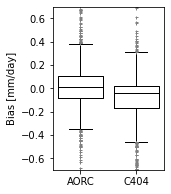

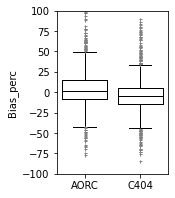

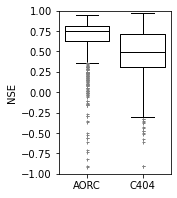

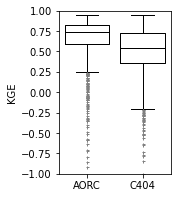

In [7]:
boxplot_metric('Bias [mm/day]', yrange=(-.7,.7))
boxplot_metric('Bias_perc', yrange=(-100,100))
boxplot_metric('NSE', yrange=(-1,1))
boxplot_metric('KGE', yrange=(-1,1))

/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


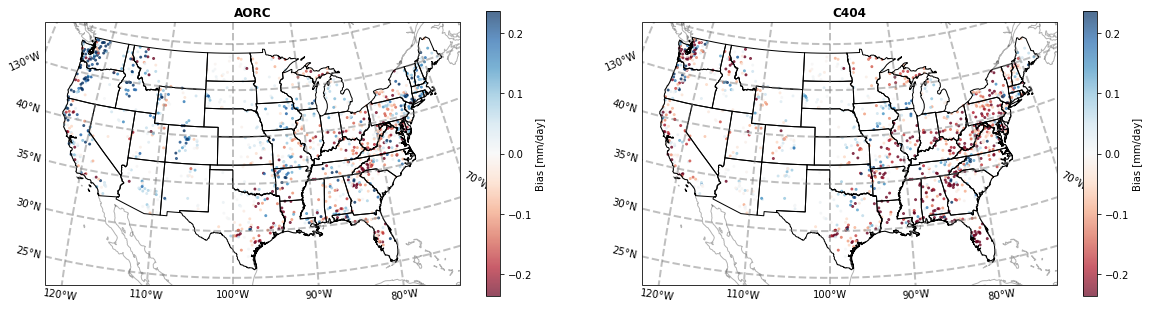

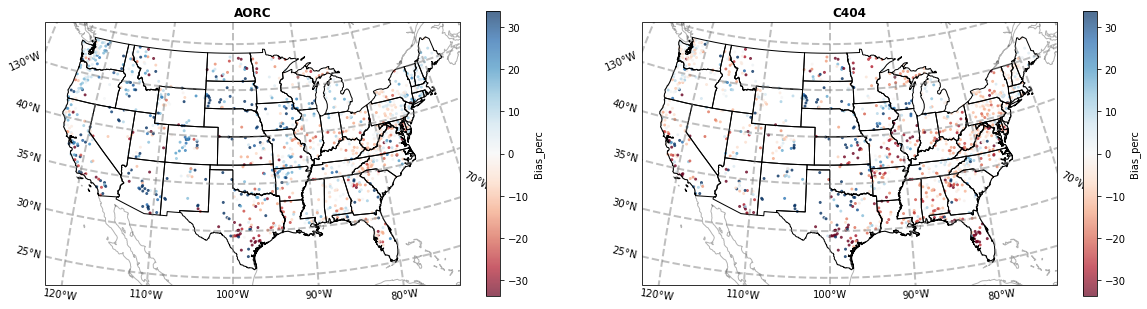

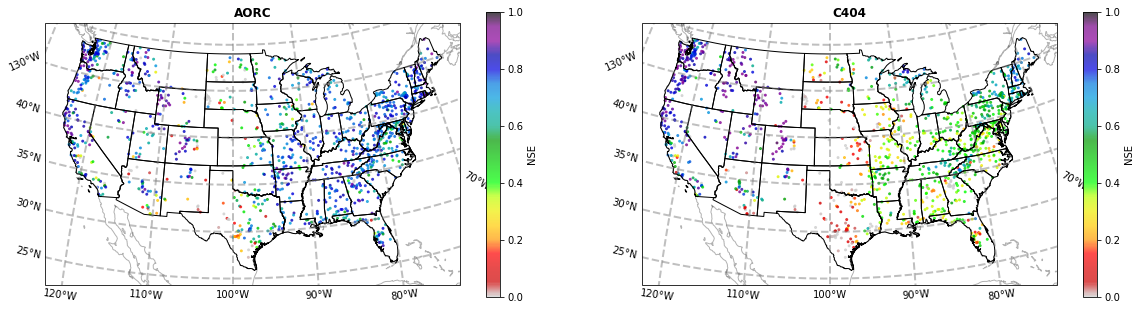

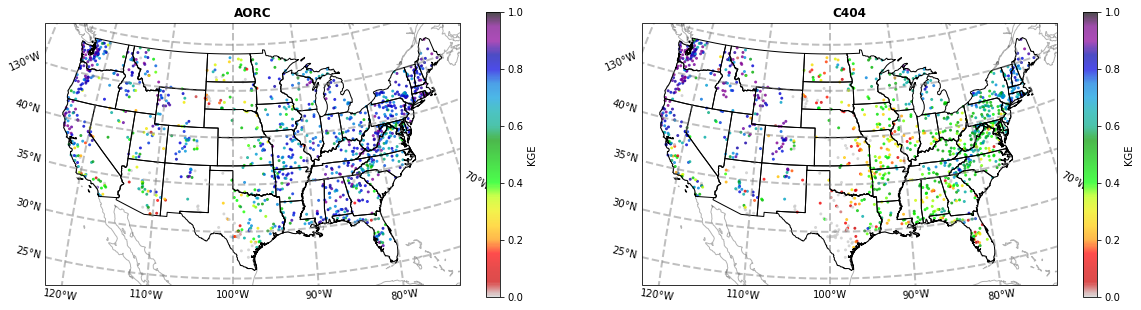

In [25]:
mapplot_metric('Bias [mm/day]', cmap='RdBu')
mapplot_metric('Bias_perc', cmap='RdBu')
mapplot_metric('NSE', cmap='nipy_spectral_r', crange=(0,1) )
mapplot_metric('KGE', cmap='nipy_spectral_r', crange=(0,1) )


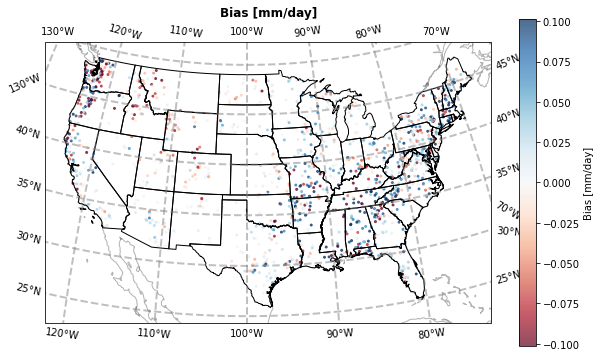

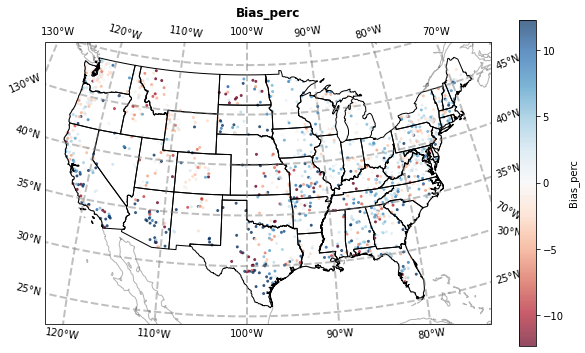

In [122]:
for varname in ['Bias [mm/day]', 'Bias_perc']:
    var = Metrics[varname]
    cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    cmin = -1 * cmax
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='RdBu', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

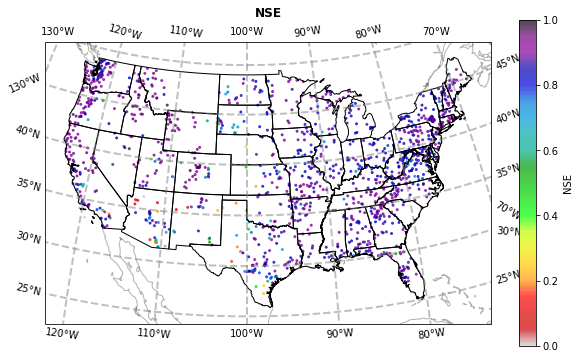

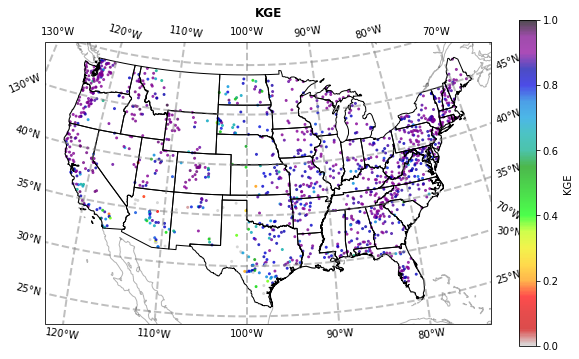

In [123]:
for varname in ['NSE', 'KGE']:
    var = Metrics[varname]
    cmin = 0
    cmax = 1
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())



### Hydrograph, single basin

In [28]:
Metrics_aorc.NSE.idxmax()

'13336500'

                qobs      qsim       err      %err
2000-10-01  2.007783  0.984894 -1.022889 -0.509462
2000-10-02  2.081823  1.208899 -0.872923 -0.419307
2000-10-03  1.085335  1.016721 -0.068615 -0.063220
2000-10-04  0.799106  0.724491 -0.074615 -0.093373
2000-10-05  0.675765  0.686517  0.010753  0.015912
...              ...       ...       ...       ...
2005-09-26  0.304347  0.373757  0.069410  0.228064
2005-09-27  0.278738  0.393964  0.115226  0.413386
2005-09-28  0.259400  0.383781  0.124380  0.479492
2005-09-29  0.248077  0.373807  0.125730  0.506820
2005-09-30  0.248599  0.394086  0.145486  0.585225

[1826 rows x 4 columns]


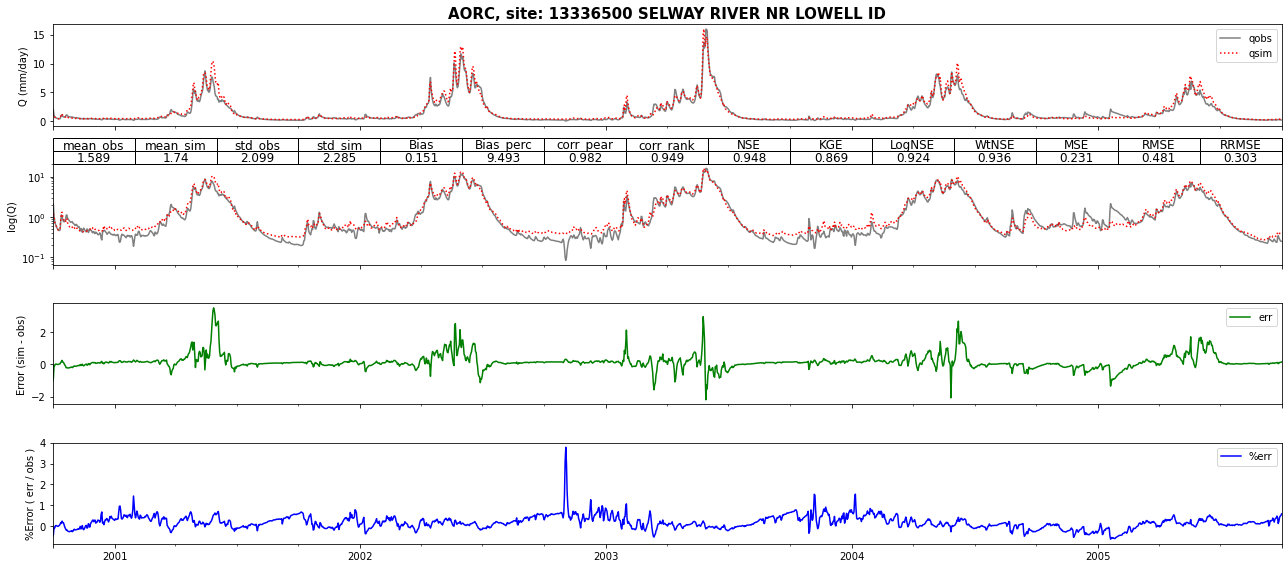

In [29]:
s = '13336500'
df = LSTM_aorc[s]
df['err'] = df.qsim - df.qobs
df['%err'] = df.err / df.qobs
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
print(df)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,8))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
df.plot.line(ax=axes[2], y=['err'], color={"err":"green"}, style=['-'], legend=True).legend(loc='upper right')
df.plot.line(ax=axes[3], y=['%err'], color={"%err":"blue"}, style=['-'], legend=True).legend(loc='upper right')
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[2].set_ylabel('Error (sim - obs)')
axes[3].set_ylabel('%Error ( err / obs )')
axes[1].set_xlabel('Date')
axes[0].set_title('AORC, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [41]:
diff = Metrics_aorc.NSE - Metrics_c404.NSE
diff[Metrics_c404.NSE>0.8].idxmin()

'06289000'

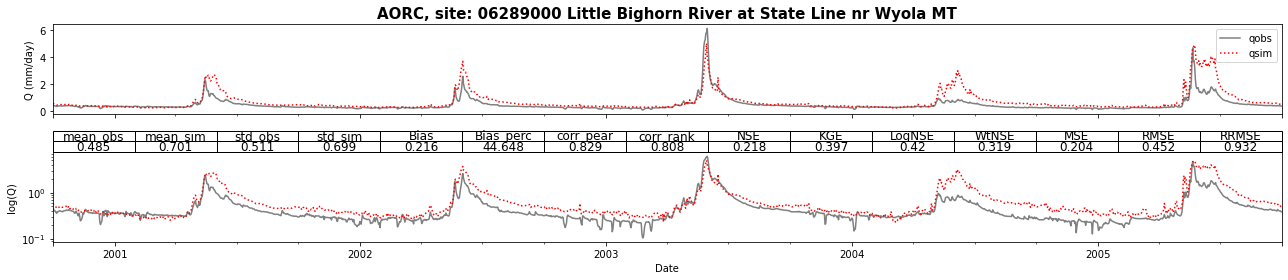

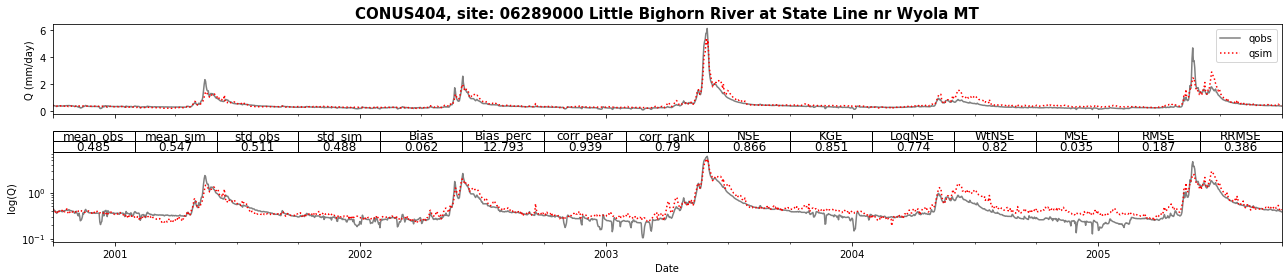

In [42]:
s = '06289000'

## First plot: AORC
df = LSTM_aorc[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('AORC, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

## Second plot: C404
df = LSTM_c404[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('CONUS404, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [127]:
verif.iloc[:, :10]

,mean_obs,mean_sim,std_obs,std_sim,Bias,Bias_perc,corr_pear,corr_rank,NSE,KGE
0,2.701746,2.461445,5.144389,4.890418,-0.2403,-8.894261,0.94638,0.980782,0.893435,0.885008
